# Spam Analysis on YouTube Comments

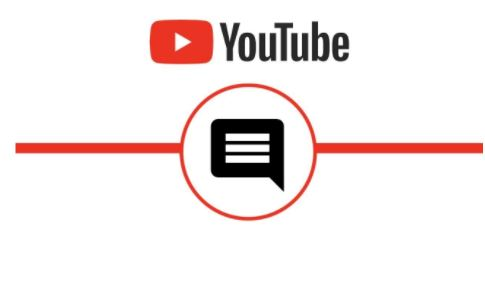

Presented by: Mustafa Furkan Kolanci

Date: 12/08/2021

Instructor: Angelica Spratley

github link: https://github.com/mfurkankolanci/CapstoneProject

## Overview

In this project, I analyze user comments on popular music videos in YouTube. The dataset includes 1,956 comments from Youtube music videos of 5 different artists (PSY, Shakira, LMFAO, Eminem and Katy Perry). This dataset fits the business problem, as the goal is to provide YouTube with a model that can predict music video comments as spam or non-spam.

For data preparation, the first step is to clean the html tags present in the comments using regex. Then, regex is used again to detect the urls in the comments. After that, comments are tokenized to split each comment into words so that each word is a feature in the model. Stopwords are also removed as they provide little to no value to the spam analysis. Lemmatization is performed to group words with the same meaning together as one word. Then, TF-IDF is applied in order to assign each word in each comment a numeric value based on its importance across all comments. 

I use pandas to perform data understanding and filtering, nltk to perform text preprocessing, and sklearn for TF-IDF.

For modeling, I use sklearn's MultinomialNB, LogisticRegression and RandomForestClassifier methods. I tune the models using GridSearchCV also provided by sklearn.

The best model has a test recall score of 87.9% and test accuracy score of 95.4%, which means that it correctly identifies the comments as spam and not spam 95.4% of the time.

## Business Understanding

As a data scientist, I was approached by a stakeholder, Youtube's maintance team. They have noticed that many popular music videos have several spam comments under them. Spam comments are undesired comments that are not related to the music video. They would like detect these comments in order to improve user experience. Therefore, they have asked me to generate a model that performs spam detection analysis in order to categorize comments as spam and not spam.

## Data Understanding

The dataset includes 1,956 Youtube comments made between 2013 and 2015. The comments are taken from music videos of PSY, Katy Perry, LMFAO, Eminem and Shakira. There are  five columns, the first column includes the  comment id, the second column is the author of comment, third column is the date of comment,  fourth column is the comment text and fifth column is whether the comment is spam (1) or not (0). 

## Data Preparation

Let's start by importing modules necessary for analysis and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Comments for each artist are in seperate csv files. Let's combine these files into a single dataframe.

In [2]:
df_Psy = pd.read_csv('Data/Youtube01-Psy.csv',encoding= 'unicode_escape')
df_katy_perry = pd.read_csv('Data/Youtube02-KatyPerry.csv',encoding= 'unicode_escape')
df_LMFAO = pd.read_csv('Data/Youtube03-LMFAO.csv',encoding= 'unicode_escape')
df_Eminem = pd.read_csv('Data/Youtube04-Eminem.csv',encoding= 'unicode_escape')
df_Shakira = pd.read_csv('Data/Youtube05-Shakira.csv',encoding= 'unicode_escape')
df = pd.concat([df_Psy,df_katy_perry,df_LMFAO,df_Eminem,df_Shakira], ignore_index=True)

The cell shown below indicates that the ratio of spam and non-spam comments are roughly equal. Therefore, there is no class imbalance to resolve.

In [3]:
df['CLASS'].value_counts(normalize=True)

1    0.513804
0    0.486196
Name: CLASS, dtype: float64

`COMMENT_ID`,`AUTHOR` and `DATE` columns provide no useful information in order to determine whether a comment is spam or not, so those columns are dropped.

In [4]:
df.drop(['COMMENT_ID','AUTHOR','DATE'],axis=1, inplace=True)

## Text Preprocessing

The comments are webscraped and therefore some comments include html syntax and tags. The html needs to be cleaned so that only the comment itself remains.

In [5]:
import html
df['CONTENT'] = df['CONTENT'].apply(html.unescape)

import re
htmlregex = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(comment):
    html_filtered_comment = re.sub(htmlregex, '', comment)
    return html_filtered_comment

df['CONTENT'] = df['CONTENT'].apply(cleanhtml)

df['CONTENT'] = df['CONTENT'].str.replace('\ufeff','')

Next, some comments include url's and these url's should be detected. The cell below detects url's and replaces them with the keyword `url`.

In [6]:
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(comment):
    url_filtered_comment = re.sub(urlregex, 'url', comment)
    return url_filtered_comment

In [7]:
df['CONTENT'] = df['CONTENT'].apply(detecturl)

Finally, many comments include non-English characters, let's filter each comment such that only characters of the English language and numbers remain.

In [8]:
alphanumericregex = re.compile(r'[^A-Za-z0-9 ]+')
def onlyalphanumeric(comment):
    alphanumeric_filtered_comment = re.sub(alphanumericregex, '', comment)
    return alphanumeric_filtered_comment

In [9]:
df['CONTENT'] = df['CONTENT'].apply(onlyalphanumeric)

Next, let's perform some feature engineering on the comments. In the following cell, let's initiate the tokenization, stopword removal and lemmatization of the comments. 

Tokenization will split each comment into its respective words so that each word be analyzed by itself in the model. 

Stopword removal is necessary as stopwords are words that provide little to no value for spam classification. 

Lemmatization is needed as it allows to group words that are from the same root so that words that have the same meaning are considered the same. This way, the model is not hurt by needlessly increasing dimensionality.

In [10]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stopwords_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

Next, let's perform a train-test split. In order to simulate a real-life scenario properly, 90% of the test set comments are non-spam and the rest are spam. The test set consists of 20% of the dataset and the rest is the training set. The training set is equally split between spam and non-spam comments, so that there is no class imbalance during training. 

In [11]:
spam = df[df['CLASS'] == 1]
nonspam = df[df['CLASS'] == 0]

spam = spam.sample(n=689)

test_spam = spam.sample(n = 33) 
train_spam = spam.drop(test_spam.index)
test_nonspam = nonspam.sample(n = 295)
train_nonspam = nonspam.drop(test_nonspam.index)

X_train = pd.concat([train_spam,train_nonspam])['CONTENT']
X_test = pd.concat([test_spam,test_nonspam])['CONTENT']
y_train = pd.concat([train_spam,train_nonspam])['CLASS']
y_test = pd.concat([test_spam,test_nonspam])['CLASS']

Now that the dataset is cleaned, lemmatized and tokenized, it can now be converted into a vector format. In order to do so, TF-IDF vectorization will be used. This method is based on the idea that rare words are more valuable for prediction. The method utilizes two metrics:
* TF (term frequency) refers to the ratio of number of times a word appear in the document to the total number of words in the document. 
* IDF (Inverse Document Frequency) refers to the logged ratio of number of documents to the number of documents including the word.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10, ngram_range=(1,2), stop_words=stopwords_list, tokenizer=lemmatize_and_tokenize)

X_train_vectorized = tfidf.fit_transform(X_train)

X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

In [13]:
X_test_vectorized = tfidf.transform(X_test)
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

## Modeling

Recall and accuracy will be used as the performance metrics for the models with recall as the priority metric. There are two types of errors that can made, false positives and false negatives. False positives in this case are comments that are predicted as spam but actually are not spam and false negatives are comments that are predicted as non-spam but actually are spam. 

For this business problem, false negatives are more important to minimize compared to false positives as if a spam comment is registered as non-spam by the model, no action can be taken toward that comment. At that point, the only way that comment can be detected is if a user notices and decides to report it as spam which defeats the purpose of the model. The model exists so that users don't have to report comments as spam. On the other hand, a non-spam comment detected as spam, while being an error, can still be resolved by notifying the user about the comment and requesting them to take action so that the comment would not be removed.   

Recall measures what percent of the spam comments present in a dataset are detected by the model, meaning that a higher recall score means less false negatives are present. This is why recall is the priority metric. As for accuracy, it measures what percent of comments are correctly labeled, which is also a useful success metric.

### Baseline Model: Dummy Regressor

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train_df,y_train)
y_test_pred_dc = dc.predict(X_test_df)

Let's use cross-validation to observe how the baseline model recall and accuracy does with unseen training data.

In [15]:
cvrs = np.mean(cross_val_score(dc,X_train_df, y_train,cv=5, scoring = 'recall'))
cvrs

0.2

In [16]:
cvas = np.mean(cross_val_score(dc,X_train_df, y_train,cv=5, scoring = 'accuracy'))
cvas

0.4992395437262357

Let's look at the confusion matrix to see how the baseline model does on the test set.

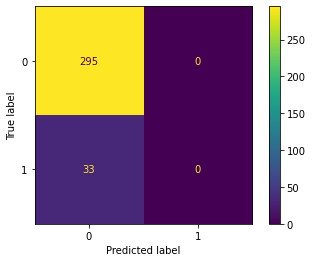

In [17]:
plot_confusion_matrix(dc,X_test_df,y_test);

Finally, let's calculate the recall and accuracy score of the baseline model on the test set.

In [18]:
trs = recall_score(y_test,y_test_pred_dc)
trs

0.0

In [19]:
tas = accuracy_score(y_test,y_test_pred_dc)
tas

0.899390243902439

In [20]:
print('Mean cross validation recall score =', round(cvrs*100, 1), '%')
print('Mean cross validation accuracy score =', round(cvas*100, 1), '%')
print('Test recall score =', round(trs*100, 1), '%')
print('Test accuracy score =', round(tas*100, 1), '%')

Mean cross validation recall score = 20.0 %
Mean cross validation accuracy score = 49.9 %
Test recall score = 0.0 %
Test accuracy score = 89.9 %


Dummy Regressor always picks the majority label, which results with a terrible recall score. Let's look at some other methods to see if we can obtain a better model.

### Model #1: Naive Bayes

Naive Bayes is selected as the first classification model as it is a fast, easy and simple classification algorithm.

In [21]:
mnb = MultinomialNB()
mnb.fit(X_train_df, y_train)
y_test_pred_mnb = mnb.predict(X_test_df)

Let's use cross-validation to observe how the Naive Bayes model recall and accuracy does with unseen training data.

In [22]:
cvrs = np.mean(cross_val_score(mnb,X_train_df, y_train,cv=5, scoring = 'recall'))
cvrs

0.8566967383761277

In [23]:
cvas = np.mean(cross_val_score(mnb,X_train_df, y_train,cv=5, scoring = 'accuracy'))
cvas

0.8363103358198124

Let's look at the confusion matrix to see how the Naive Bayes model does on the test set.

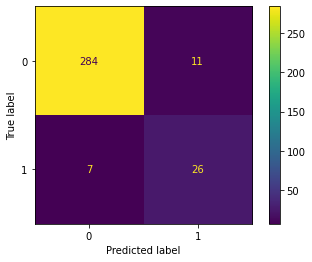

In [24]:
plot_confusion_matrix(mnb,X_test_df,y_test);

Finally, let's calculate the recall and accuracy score of the Naive Bayes model on the test set.

In [25]:
trs = recall_score(y_test,y_test_pred_mnb)
trs

0.7878787878787878

In [26]:
tas = accuracy_score(y_test,y_test_pred_mnb)
tas

0.9451219512195121

In [27]:
print('Mean cross validation recall score =', round(cvrs*100, 1), '%')
print('Mean cross validation accuracy score =', round(cvas*100, 1), '%')
print('Test recall score =', round(trs*100, 1), '%')
print('Test accuracy score =', round(tas*100, 1), '%')

Mean cross validation recall score = 85.7 %
Mean cross validation accuracy score = 83.6 %
Test recall score = 78.8 %
Test accuracy score = 94.5 %


Naive Bayes does much better than the dummy regressor model, however, there is still room for improvement.

### Model #2: Logistic Regression

Logistic Regression is selected as the second model as it is a simple classification algorithm which is computationally efficient. `GridSearchCV` will be utilized in order to try different hyperparameters and optimize the model.

In [28]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
param_grid =  {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : [1,100,10000]
}
gs_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
gs_logreg.fit(X_train_df, y_train)
gs_logreg.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [29]:
lr = LogisticRegression(C = 100, penalty = 'l2', solver = 'newton-cg')
lr.fit(X_train_df, y_train)

LogisticRegression(C=100, solver='newton-cg')

Let's use cross-validation to observe how the tuned Logistic Regression model recall and accuracy does with unseen training data.

In [30]:
cvrs = np.mean(cross_val_score(lr,X_train_df, y_train,cv=5, scoring = 'recall'))
cvrs

0.8566851723340273

In [31]:
cvas = np.mean(cross_val_score(lr,X_train_df, y_train,cv=5, scoring = 'accuracy'))
cvas

0.9009781441383915

Let's look at the confusion matrix to see how the model does on the test set.

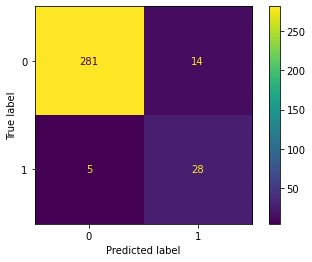

In [32]:
plot_confusion_matrix(lr,X_test_df,y_test);

Finally, let's calculate the recall and accuracy score of the tuned Logistic Regression model on the test set.

In [33]:
y_test_pred_logreg = lr.predict(X_test_df)
trs = recall_score(y_test,y_test_pred_logreg)
trs

0.8484848484848485

In [34]:
tas = accuracy_score(y_test,y_test_pred_logreg)
tas

0.9420731707317073

In [35]:
print('Mean cross validation recall score =', round(cvrs*100, 1), '%')
print('Mean cross validation accuracy score =', round(cvas*100, 1), '%')
print('Test recall score =', round(trs*100, 1), '%')
print('Test accuracy score =', round(tas*100, 1), '%')

Mean cross validation recall score = 85.7 %
Mean cross validation accuracy score = 90.1 %
Test recall score = 84.8 %
Test accuracy score = 94.2 %


Logistic Regression does slightly better on the test set than the Naive Bayes model. Let's try a more advanced model.

### Model #3: Random Forest

Random Forest is selected as the third and final model as it is an ensemble model which means it is more immune to overfitting and usually has stronger performance compared to simpler models such as Logistic Regression and Naive Bayes. Once again `GridSearchCV` will be utilized in order to try different hyperparameters and optimize the model.

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
param_grid = {'n_estimators':[100,200,500],
              'criterion':['gini','entropy'],
              'max_depth':[50,100,200]           
}
gs_forest = GridSearchCV(forest, param_grid, cv=5, scoring='recall')
gs_forest.fit(X_train_df, y_train)
gs_forest.best_params_

{'criterion': 'gini', 'max_depth': 50, 'n_estimators': 200}

In [37]:
rf = RandomForestClassifier(criterion = 'gini',max_depth = 50, n_estimators=200)
rf.fit(X_train_df, y_train)

RandomForestClassifier(max_depth=50, n_estimators=200)

Let's use cross-validation to observe how the tuned random forest model recall and accuracy does with unseen training data. 

In [38]:
cvrs = np.mean(cross_val_score(rf,X_train_df, y_train,cv=5, scoring = 'recall'))
cvrs

0.8490631505898681

In [39]:
cvas = np.mean(cross_val_score(rf,X_train_df, y_train,cv=5, scoring = 'accuracy'))
cvas

0.9017356979072939

Let's look at the confusion matrix to see how the tuned random forest does on the test set.

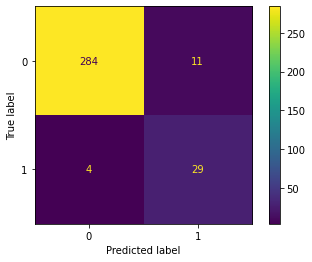

In [40]:
plot_confusion_matrix(rf,X_test_df,y_test);

Finally, let's calculate the recall and accuracy score of the tuned random forest model on the test set.

In [41]:
y_test_pred_rf = rf.predict(X_test_df)
trs = recall_score(y_test,y_test_pred_rf)
trs

0.8787878787878788

In [42]:
tas = accuracy_score(y_test,y_test_pred_rf)
tas

0.9542682926829268

In [43]:
print('Mean cross validation recall score =', round(cvrs*100, 1), '%')
print('Mean cross validation accuracy score =', round(cvas*100, 1), '%')
print('Test recall score =', round(trs*100, 1), '%')
print('Test accuracy score =', round(tas*100, 1), '%')

Mean cross validation recall score = 84.9 %
Mean cross validation accuracy score = 90.2 %
Test recall score = 87.9 %
Test accuracy score = 95.4 %


Random Forest does slightly better on the test set than the Logistic Regression model.

# Conclusion

The goal of this project is to generate a model to perform spam analysis on popular music video comments on YouTube. To do so, three classification models are created, with the best model having a test recall score of 87.9% and test accuracy score of 95.4%. The project provides the stakeholder with the model so that it can be applied on other YouTube comments.

I recommend that the model should only used to detect spam comments under music videos. The dataset only includes music video comments, therefore one should be cautious of applying this model on comments from non-music videos. Another recommendation is that this model should be used to flag the detected spam comments for further analysis and not remove them. Although the model has very high spam detection accuracy, it shouldn't be used to remove a comment right away as removing a comment disrupts a user's ability to freely express their opinion on YouTube.

# Future Research

The dataset used has around 2,000 comments. Popular music videos tend to have hundreds of thousands of comments each with many non-English comments, therefore the model can be altered to analyze non-English comments as well for a wider range of spam detection capability. Another future work that can be done is identifying accounts that tend to make spam comments. The model can be used to track the frequency and amount of spam comments made by each account and therefore can flag accounts as spam or non-spam. 

Finally, the model can be tested on non-music video comments as well. If the model performance doesn't suffer, the model can be generalized to videos with other genres as well and if it does suffer, alternative models can be generated for comments of different genres.